# Heart Disease Prediction — Complete Machine Learning Pipeline

This notebook builds a full ML pipeline for predicting heart disease:
- Load & explore dataset  
- Data cleaning  
- Preprocessing with Pipelines  
- Train multiple models  
- Cross-validation & hyperparameter tuning  
- Model comparison & best-model selection  
- Performance evaluation (accuracy, classification report, confusion matrix, ROC)  
- Save final trained model as a .pkl file  


## 1. Imports

We load the required libraries for:
- Data handling (pandas, numpy)
- Visualization (matplotlib, seaborn)
- Modeling, scaling, and evaluation (scikit-learn)
- Saving the final model (joblib)


In [14]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)

import joblib

plt.style.use("default")


## 2. Load Dataset
We load the `heart.csv` dataset and inspect its structure and properties.


In [15]:
df = pd.read_csv("heart.csv")

print("Original shape:", df.shape)
display(df.head())

print("\nData info:")
print(df.info())

print("\nTarget value counts:")
print(df["target"].value_counts())


Original shape: (1025, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0



Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB
None

Target value counts:
target
1    526
0    499
Name: count, dtype: int64


## 3. Data Quality Check  
We inspect missing values and duplicates.




In [16]:
print("Missing values per column:")
print(df.isna().sum())

# Check duplicates
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicated rows: {duplicates}")

if duplicates > 0:
    df = df.drop_duplicates()
    print("New shape after removing duplicates:", df.shape)


Missing values per column:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Number of duplicated rows: 723
New shape after removing duplicates: (302, 14)


## 4. Exploratory Data Analysis (EDA)  
We visualize distributions and correlations.


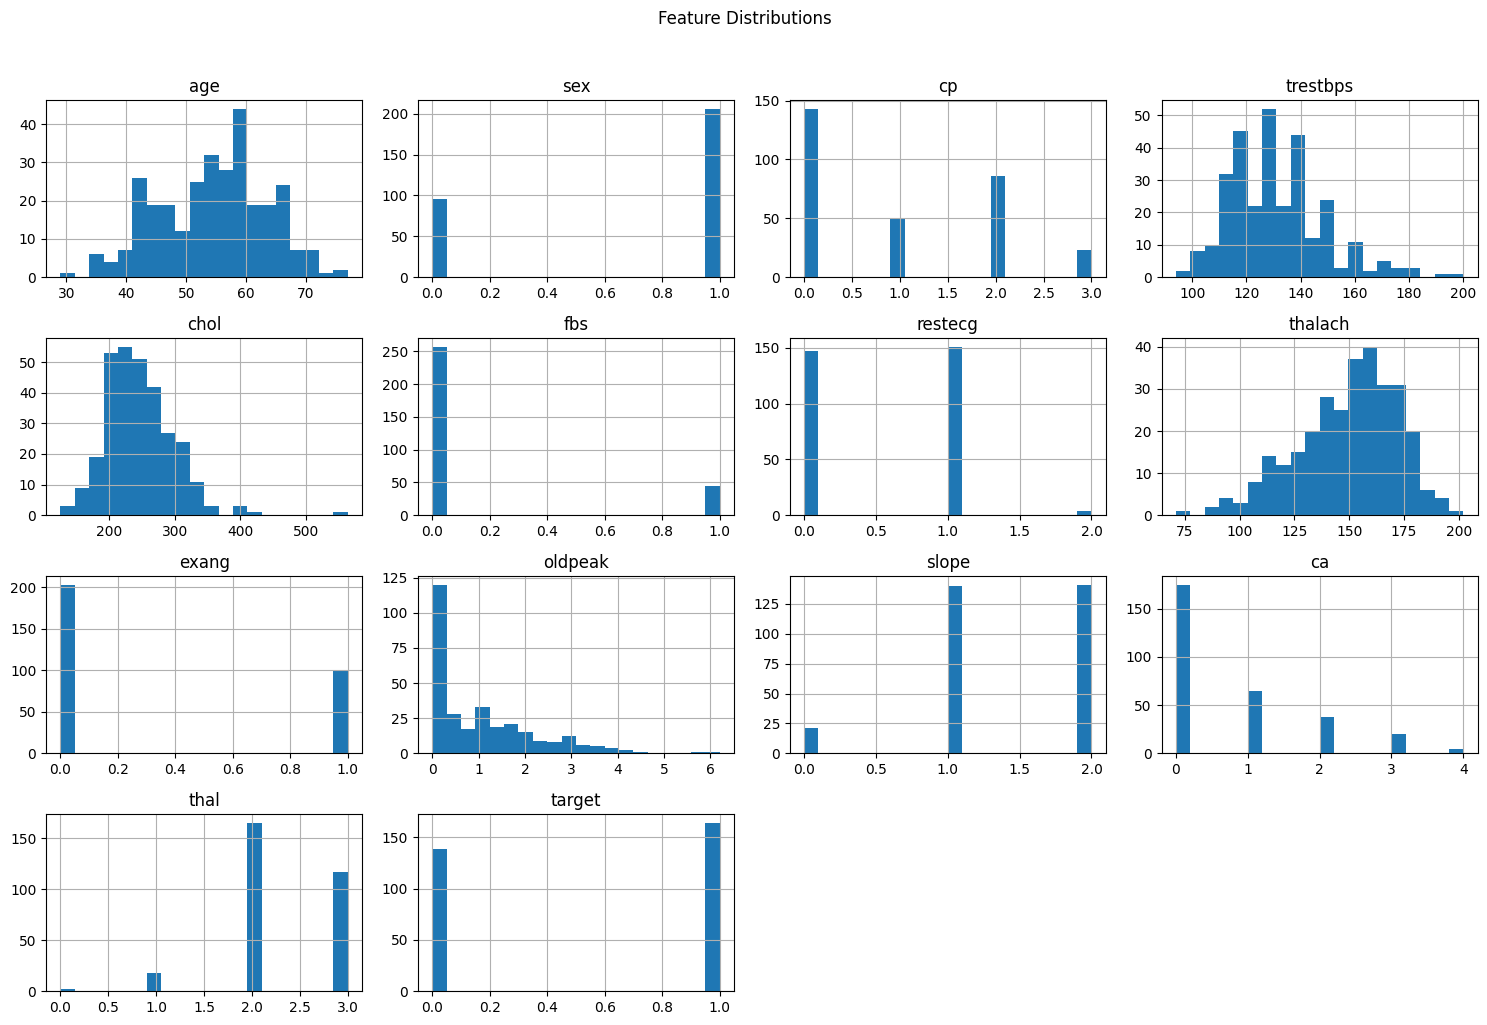

In [17]:
df.hist(figsize=(15, 10), bins=20)
plt.suptitle("Feature Distributions", y=1.02)
plt.tight_layout()
plt.show()


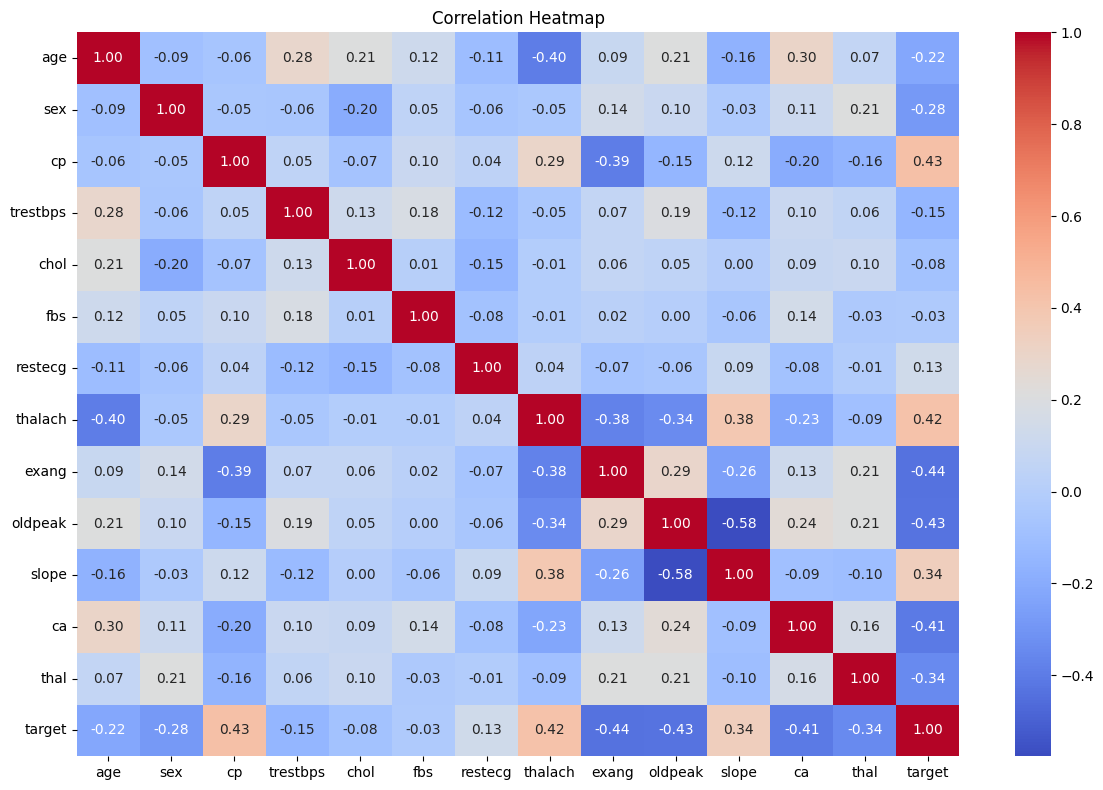

In [18]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


## 5. Train/Test Split  
We split the dataset using stratification to preserve class distribution.


In [19]:
X = df.drop("target", axis=1)
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Training shape:", X_train.shape)
print("Test shape:", X_test.shape)


Training shape: (241, 13)
Test shape: (61, 13)


## 6. Define Base Pipelines  
Each model is wrapped in a Pipeline that includes StandardScaler.


In [20]:
base_pipelines = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000))
    ]),
    "Random Forest": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", RandomForestClassifier(random_state=42))
    ]),
    "KNN": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", KNeighborsClassifier())
    ]),
    "SVC": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(probability=True, random_state=42))
    ]),
}


## 7. Cross-Validation on Base Models  
We evaluate each model using 5-fold cross-validation.


In [21]:
cv_results = {}

for name, pipe in base_pipelines.items():
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="accuracy", n_jobs=-1)
    cv_results[name] = (scores.mean(), scores.std())
    print(f"{name}: mean accuracy = {scores.mean():.4f} ± {scores.std():.4f}")


Logistic Regression: mean accuracy = 0.8216 ± 0.0210
Random Forest: mean accuracy = 0.8173 ± 0.0340
KNN: mean accuracy = 0.8093 ± 0.0396
SVC: mean accuracy = 0.8132 ± 0.0327


## 8. Hyperparameter Tuning with GridSearchCV  
We tune all four models and store their best versions.


In [22]:
param_grids = {
    "Logistic Regression": {
        "clf__C": [0.01, 0.1, 1, 10],
        "clf__penalty": ["l2"],
        "clf__solver": ["lbfgs", "liblinear"]
    },
    "Random Forest": {
        "clf__n_estimators": [100, 300, 500],
        "clf__max_depth": [None, 5, 10, 20],
        "clf__min_samples_split": [2, 5, 10]
    },
    "KNN": {
        "clf__n_neighbors": [3, 5, 7, 9],
        "clf__weights": ["uniform", "distance"],
        "clf__p": [1, 2]
    },
    "SVC": {
        "clf__C": [0.1, 1, 10],
        "clf__gamma": ["scale", 0.01, 0.001],
        "clf__kernel": ["rbf"]
    }
}

best_models = {}
best_scores = {}

for name, pipe in base_pipelines.items():
    print(f"\n=== Grid Search for {name} ===")
    grid = GridSearchCV(pipe, param_grids[name], cv=5, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train, y_train)

    best_models[name] = grid.best_estimator_
    best_scores[name] = grid.best_score_

    print("Best CV accuracy:", grid.best_score_)
    print("Best parameters:", grid.best_params_)



=== Grid Search for Logistic Regression ===
Best CV accuracy: 0.825765306122449
Best parameters: {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}

=== Grid Search for Random Forest ===
Best CV accuracy: 0.8421768707482993
Best parameters: {'clf__max_depth': 5, 'clf__min_samples_split': 5, 'clf__n_estimators': 500}

=== Grid Search for KNN ===
Best CV accuracy: 0.8299319727891156
Best parameters: {'clf__n_neighbors': 9, 'clf__p': 2, 'clf__weights': 'uniform'}

=== Grid Search for SVC ===
Best CV accuracy: 0.8297619047619047
Best parameters: {'clf__C': 10, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}


## 9. Select the Best Model  
We choose the model with the highest cross-validation accuracy.


In [23]:
best_model_name = max(best_scores, key=best_scores.get)
best_model = best_models[best_model_name]

print("Best model:", best_model_name)
print("Best CV accuracy:", best_scores[best_model_name])

# Fit on the training data if needed
best_model.fit(X_train, y_train)

# Predictions
y_pred = best_model.predict(X_test)

test_acc = accuracy_score(y_test, y_pred)
print(f"\nTest accuracy ({best_model_name}): {test_acc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Best model: Random Forest
Best CV accuracy: 0.8421768707482993

Test accuracy (Random Forest): 0.7705

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        28
           1       0.79      0.79      0.79        33

    accuracy                           0.77        61
   macro avg       0.77      0.77      0.77        61
weighted avg       0.77      0.77      0.77        61



## 10. Confusion Matrix


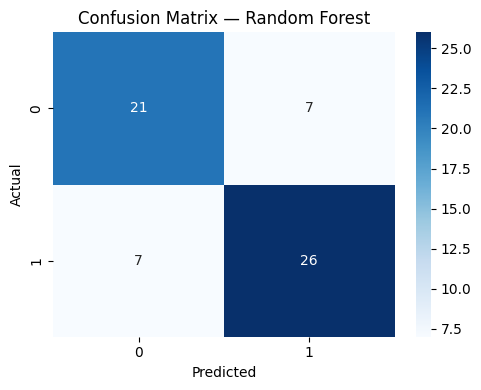

In [24]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix — {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


## 11. ROC Curve & AUC  


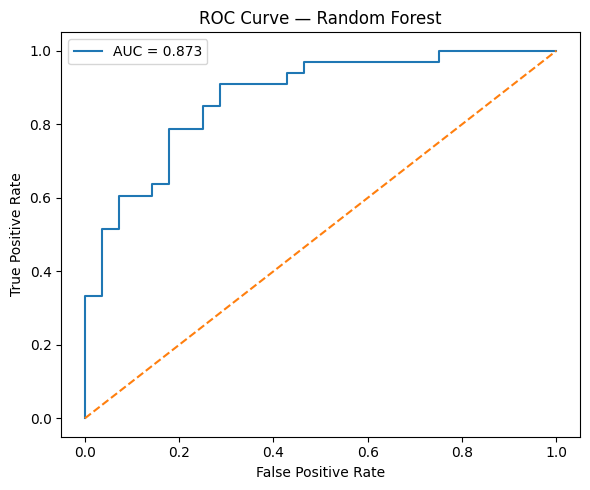

In [25]:
if hasattr(best_model, "predict_proba"):
    y_proba = best_model.predict_proba(X_test)[:, 1]
else:
    y_scores = best_model.decision_function(X_test)
    y_proba = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min())

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title(f"ROC Curve — {best_model_name}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()


## 12. Feature Importances (Tree Models Only)


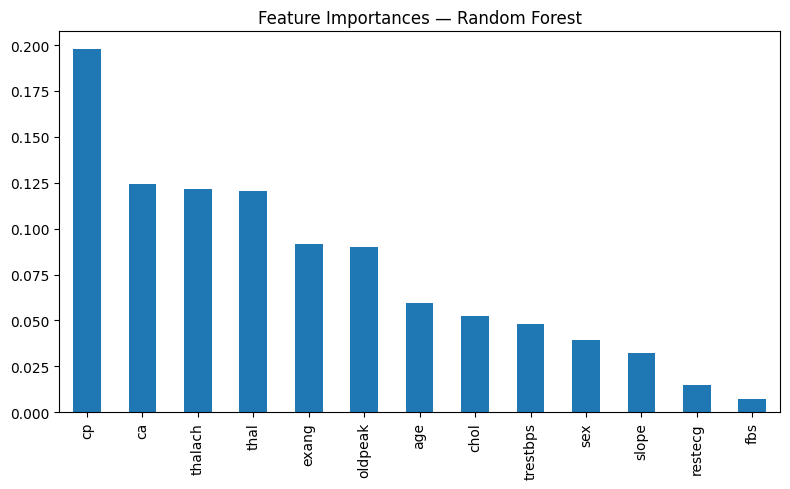

In [26]:
clf = best_model.named_steps["clf"]

if hasattr(clf, "feature_importances_"):
    importances = pd.Series(
        clf.feature_importances_,
        index=X.columns
    ).sort_values(ascending=False)

    plt.figure(figsize=(8, 5))
    importances.plot(kind="bar")
    plt.title(f"Feature Importances — {best_model_name}")
    plt.tight_layout()
    plt.show()
else:
    print(f"{best_model_name} does not support feature_importances_.")


## 13. Save Final Model  
We save the entire pipeline (scaler + model) as a .pkl file.


In [27]:
joblib.dump(best_model, "best_model.pkl")
print(f"Saved best model: {best_model_name} → best_model.pkl")


Saved best model: Random Forest → best_model.pkl
